#Project 3: Data Wrangling Open Streetmaps Data
---

##References:
>http://effbot.org/zone/element-iterparse.htm#incremental-parsing

>https://www.aggdata.com/free/norway-postal-codes

---

##1. Problems encountered in the map
####I decided to go for my hometown of Oslo, Norway, and naturally there was a bit of trouble with the non-English characters found there. I made two translation mappings, one for unicode and one for normal strings, for both small and capital æ,ø,å. Also, most of the addresses were missing a postal code.

### Non-English characters
#### The non-English characters in the dataset have different encodings, both unicode and standard. This called for two different approaches to translating these to the standard English representation of Scandinavian letters. I made two mappings in Python dicts, one for unicode and one for standard. Then, each streetname string was searched for the respective characters, and replaced with the English representation, e.g Ø was translated to Oe, æ was translated to ae. 

#### As an example, the name "Bygdøy" was translated to "Bygdoey".


### Postal Codes
#### A quite significant ammount of the entries (91,6%)  had postal code "None". I downloaded a spreadsheet with all post codes in Norway coupled with several positions from https://www.aggdata.com/free/norway-postal-codes. I removed those entries not from Oslo, saved as a csv and imported it with pandas. Taking a nearest-neighbour approach, I found the closest (L2-Norm) point with postal code for all those entries currently without a postal code, and made that the new postal code. Not always strictly correct of course, but better than nothing! 
#### I only did this for street addresses, since doing it for the entire data set would have been to heavy for my computer (finding nearest neighbour of 500k points to a set of 620 points).
---

##2. Overview of the data

###File sizes
#### oslo.osm .. 50,1 MB
#### oslo.json .. 95,6 MB

###Some selected data
#### The number of documents in the set is 472,112, 417.088 of which are nodes and 55,024 are ways.
db.oslo.find().count()
list(db.oslo.aggregate(nodes_and_ways))

nodes_and_ways = [{"\$group":{"_id":"\$type","count":{"\$sum":1 \}\}\},{"$sort":{"count":-1}}]

#### There are 454 distinct contributors, the most active being 'Turleder'n', who's commited 221,584 (46,9\%)of the 472,112 documents.
len(db.oslo.distinct('created.user'))
list(db.oslo.aggregate(top_user))

top_user = [{"\$group":{"_id":"\$created.user","count":{"\$sum":1\}\}\},{"\$sort":{"count":-1}},{"\$limit":1}]

#### There are 957 distinct street addresses in the set.
len(db.oslo.distinct('address.street'))

---

##3. Other ideas about the dataset
###Addresses per postal code
####Though it would be interesting to see the number of addresses per top 5 postal codes, before and after the assignment algorithm had run on it.
####Results before assignment from algorithm:
None: 1223

0374: 1060

0375: 990

0851: 842

0373: 787

####After algorithm
0374: 1060

0375: 992

0851: 842

0001: 840

0373: 787

####As we can see, most of the points were added to the post code 0001. 

#### I used the aggregation
addresses_per_postal_code = [{"\$match":{"address":{"\$exists": True\}\}\},{"\$group":{"_id":"\$address.postcode","count":{"\$sum":1}}},{"\$sort":{"count":-1}\},{"$limit":5}]

###Different types of nodes
#### 455 of the documents, with tag node or way, had a field for type in the dataset. I saved these types as type_2, and most of them turned out to be either individual(node) trees or lanes(way) of trees, all broad leaved trees.
#### type_2 entries:
#### broad_leaved, node: 411
#### broad_leaved, way: 26
#### Autopass, node: 12
#### Route, way: 2
#### public_transport, node: 2
#### multi_polygon,way: 2

####Found using:
type_2 = [{"\$match":{"type_2":{"\$exists":True}}},{"\$group":{"_id":{"type":"\$type","type_2":"\$type_2"},"count":{"\$sum":1}}},{"\$sort":{"count":-1}}]

###Dates of entries
#### Having a look at the dates of the entries, we can see that most of the entries are from 2011, with 2014 coming in second. Histogram at the bottom of the submission.


###Postal codes:
#### It seems to have been a practice to not include postal code in a lot of the submissions. This could be changed by demanding an entry for the post code on certain entries. A better approach would be to obtain a sufficiently accurate mapping from position to postal code, and have it automatically added to the record upon submission. This should be pretty easy to implement (as long as such a mapping can be made), ensure data quality, all the while not making things any more complicated for the person submitting the entry.

###Potential problem with translating characters
####It's a posibility, however pretty rare, that when translating special characters to English standard, you'll change the old word into an already existing area name. In other words, there are distinct street names that would all of a sudden no longer be distinct. This could lead to confusion, and make the data less accurate. An option here is to add a new field informing that the name has been Englified whenever a letter has been changed, to distinguish between Overaa (Translated from Overå) vs. Overaa (not translated from anything).

---

##4. Conclusion
#### The biggest problem found with the dataset is the almost complete lack of postal codes. I made an attempt at fixing this with my new code, but the resolution of points per postal code isn't very high, so it's highly likely that some points now have a wrong postal code. Whether a change like that is acceptable is hard to determine without knowing the application for the data, but I did it anyways.

----

#The code:

In [12]:
import xml.etree.ElementTree as ET
import pprint
import re
import codecs
import json
import time
from pymongo import MongoClient
%pylab inline
file_path = 'C:\Users\hakon.tromborg\Data Analyst Nanodegree\Data\\oslo.osm'

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [13]:
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

CREATED = [ "version", "changeset", "timestamp", "user", "uid"]

#json->MongoDB can't handle the Norwegian letters, so I'm mapping them to their official [a-z] equivalents for both unicode
#and normal strings
letter_map = {u"Å":'Aa',
              u"Ø":'Oe',
              u"Æ":'Ae',
              u"å":"aa",
              u"ø":"oe",
              u"æ":"ae"}
unicode_map = {u"\xc5":'Aa',
              u"\xd8":'Oe',
              u"\xc6":'Ae',
              u"\xe5":"aa",
              u"\xf8":"oe",
              u"\xe6":"ae"}

In [14]:
#Code to approximate the postcodes

import pandas as pd
#Downloaded poisitions for Oslo's post codes from 
#https://www.aggdata.com/free/norway-postal-codes
df = pd.read_csv('C:\Users\hakon.tromborg\Data Analyst Nanodegree\Data\\postcode_oslo.csv')

df['Postal Code String'] = (3*'0' +  df['Postal Code'].astype(str))
f = lambda x: x[-4:]
df['Postal Code String'] = df['Postal Code String'].apply(f)

def get_post_code(lat,lon,df):
    min = Inf
    for x in xrange(df.shape[0]):
        s = (double(lat)-df['Latitude'][x])**2+(double(lon)-df['Longitude'][x])**2
        if(s<min):
            min = s
            best = df['Postal Code String'][x]
    return best

In [15]:
#From chapter 6
def process_map(file_in, pretty = False):
    # You do not need to change this file
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        # get an iterable
        context = ET.iterparse(file_in, events=("start", "end"))

        # turn it into an iterator
        context = iter(context)
        
        # get the root element
        event, root = context.next()
        
        
        for _, element in context:
            el = shape_element(element)
            if el:
                data.append(el)
                #fo.write(json.dumps(el) + "\n")
            root.clear()
        fo.write(json.dumps(data) + "\n")

In [16]:
def shape_element(element):
    node = {}
    
    node['created'] = {}
    if element.tag in ["node","way"]:
        node['type'] = element.tag
        if element.tag == "way":
            node['node_refs'] = []
            for it in element.iter("nd"):
                node['node_refs'].append(it.attrib['ref'])

        for a in element.attrib:
            if a in CREATED:
                node['created'][a] = element.attrib[a]
            elif a == 'pos' or 'lat':
                #Ensure 'pos' only shows up in documents with a latitude/longitude
                if 'pos' not in node:
                    node['pos'] = ["0","0"]
                if a == "lat":
                    node['pos'][0]=(float(element.attrib[a]))
                elif a == "lon":
                    node['pos'][1]=(float(element.attrib[a]))
            else:
                node[a] = element.attrib[a]
                

        for it in element.iter("tag"):
            #Skip the iteration and drop the element if problemchars are discovered
            e = problemchars.search(it.attrib['k'])
            if e:
                continue
                
            elif it.attrib['k'][:5] == "addr:":
                if 'address' not in node:
                    node['address'] = {}
                c = it.attrib['k'].split(':')
                
                #If c is 2, there's exactly one : in the string, which is the format we're looking for
                if len(c) == 2:
                    translated_string = translate_string(it.attrib['v'])
                    #Translating Norwegian letters proved more difficult than expected 
                    #because the set contains both unicode and normal strings
                    node['address'][it.attrib['k'][5:]] = translated_string
            elif (it.attrib['k'] == "type") and (it.attrib['k'] not in ["node","way"]) :
                node['type_2'] = it.attrib['v']
            
            else:    
                node[it.attrib['k']] = it.attrib['v']
        if 'address' in node:
            if 'postcode' not in node['address']:
                node['address']['postcode'] = get_post_code(node['pos'][0],node['pos'][1],df)
        return node
    else:
        return None
    
def translate_string(str):
    if type(str) is unicode:
        translated_string = translate_unicode(str)
        return translated_string
    else:
        translated_string = translate_utf(str)
        return translated_string
    
def translate_unicode(addr):
    for l in unicode_map:
        if l in list(addr):
            #using if l in letter_map crashes with unicode characters because illegal decodings are attempted
            addr = [c.replace(l, unicode_map[l]) for c in list(addr)]
            addr = ''.join(addr)
    return addr
def translate_utf(addr):
    for l in letter_map:
        if l in addr:
            addr = addr.replace(l,letter_map[l])
    return addr

In [17]:
def process_file():
    data = process_map(file_path, False)

In [18]:
t0 = time.time()
process_file()
print time.time()-t0

53.1920001507


In [19]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

OSM_FILE = file_path  # Replace this with your osm file
SAMPLE_FILE = "C:\Users\hakon.tromborg\Data Analyst Nanodegree\Data\\oslo_sample.osm"


def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag

    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


with open(SAMPLE_FILE, 'wb') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')

    # Write every 10th top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % 10 == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write('</osm>')

In [19]:
def insert_data(data, db):
    db.oslo.insert(data)

In [20]:
client = MongoClient("mongodb://localhost:27017")
db = client.oslo
#Clear the database to avoid adding multiple records
db.oslo.remove()

t0 = time.time()
with open(file_path + '.json') as f:
        data = json.loads(f.read())
        insert_data(data, db)
print time.time()-t0

35.876999855


In [21]:
nodes_and_ways = [{"$group":{"_id":"$type",
                      "count":{"$sum":1}}},
            {"$sort":{"count":-1}}
                 ]

top_user = [{"$group":{"_id":"$created.user",
                            "count":{"$sum":1}}},
                           {"$sort":{"count":-1}},
                           {"$limit":1}]
addresses_per_postal_code = [{"$match":{"address":{"$exists": True}}},
                            {"$group":{"_id":"$address.postcode",
                            "count":{"$sum":1}}},
                           {"$sort":{"count":-1}},
                            {"$limit":5}]

print "Number of records:"
print db.oslo.find().count()

print "Number of nodes and ways:"
pprint.pprint(list(db.oslo.aggregate(nodes_and_ways)))

print "Number of unique users:"
print len(db.oslo.distinct('created.user'))

print "Top contributing user:"
print list(db.oslo.aggregate(top_user))

print "Distinct street addresses in set:"
print len(db.oslo.distinct('address.street'))

print "Distinct postal codes: "
print len(db.oslo.distinct('address.postcode'))

print "Number of addresses per postal code: "
print list(db.oslo.aggregate(addresses_per_postal_code))

Number of records:
472112
Number of nodes and ways:
[{u'_id': u'node', u'count': 417088}, {u'_id': u'way', u'count': 55024}]
Number of unique users:
454
Top contributing user:
[{u'count': 221584, u'_id': u"Turleder'n"}]
Distinct street addresses in set:
957
Distinct postal codes: 
215
Number of addresses per postal code: 
[{u'count': 1064, u'_id': u'0374'}, {u'count': 992, u'_id': u'0375'}, {u'count': 842, u'_id': u'0851'}, {u'count': 840, u'_id': u'0001'}, {u'count': 787, u'_id': u'0373'}]


In [10]:
addresses_no_postal_code = [{"$match":{"address.postcode":None}},
                            {"$group":{"_id":"address'postcode",#{"type":"$type","type_2":"$type_2"},
                            "count":{"$sum":1}}},
                           {"$sort":{"count":-1}},
                            {"$limit":10}]

type_2 = [{"$match":{"type_2":{"$exists":True}}},
                            {"$group":{"_id":{"type":"$type","type_2":"$type_2"},
                            "count":{"$sum":1}}},
                           {"$sort":{"count":-1}}
                            ]

print list(db.oslo.aggregate(addresses_no_postal_code))


print list(db.oslo.aggregate(type_2))

[{u'count': 431677, u'_id': u"address'postcode"}]
[{u'count': 411, u'_id': {u'type_2': u'broad_leaved', u'type': u'node'}}, {u'count': 26, u'_id': {u'type_2': u'broad_leaved', u'type': u'way'}}, {u'count': 12, u'_id': {u'type_2': u'Autopass', u'type': u'node'}}, {u'count': 2, u'_id': {u'type_2': u'multipolygon', u'type': u'way'}}, {u'count': 2, u'_id': {u'type_2': u'route', u'type': u'way'}}, {u'count': 2, u'_id': {u'type_2': u'public_transport', u'type': u'node'}}]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BC00A20>]], dtype=object)

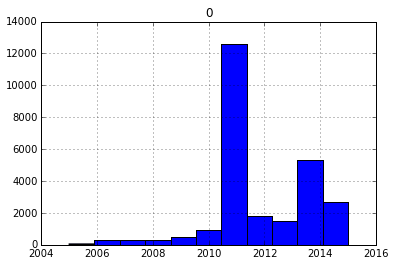

In [11]:
import pandas as pd
times = db.oslo.distinct('created.timestamp')
for x,t in enumerate(times):
    times[x] = int(times[x][:4])
#print sorted(times)
d = pd.DataFrame(sorted(times))
d.hist(bins = 11)